# Importar as Bibliotecas

In [208]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import shuffle
import math


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# Carregar os dados

In [209]:
try:
    df = pd.read_csv('insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

In [210]:
display(df.sample(10))

,Gender,Age,Salary,Family members,Insurance benefits
1419,0,20.0,30200.0,4,0
4832,1,30.0,34300.0,2,0
4529,1,35.0,22100.0,1,0
1480,0,42.0,31900.0,1,1
3019,0,33.0,33700.0,2,0
4755,0,31.0,40700.0,0,0
4392,0,36.0,35400.0,1,0
4201,1,26.0,35300.0,1,0
4057,1,43.0,47600.0,1,1
3427,1,23.0,21800.0,0,0


In [211]:
df = df.rename(columns={'Gender':'gender',
                        'Age':'age',
                        'Salary':'salary',
                        'Family members':'family_members',
                        'Insurance benefits':'insurance_benefits'})

display(df.sample(10))

,gender,age,salary,family_members,insurance_benefits
4353,0,29.0,60400.0,0,0
3196,1,37.0,33500.0,0,0
2438,1,25.0,49600.0,6,0
2336,0,21.0,33200.0,1,0
804,0,41.0,61200.0,1,0
3106,1,30.0,45200.0,0,0
3758,0,23.0,24100.0,0,0
3774,1,46.0,39400.0,2,1
3825,1,21.0,55400.0,0,0
1415,1,39.0,39900.0,2,0


In [212]:
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [213]:
display(df.describe().T)
print('-'*90)
print('Dados duplicados:', df.duplicated().sum())
print('-'*90)
print('Dados ausentes:')
print(df.isna().sum())

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
salary,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
family_members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
insurance_benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


------------------------------------------------------------------------------------------
Dados duplicados: 153
------------------------------------------------------------------------------------------
Dados ausentes:
gender                0
age                   0
salary                0
family_members        0
insurance_benefits    0
dtype: int64


In [214]:
duplicated = df[df.duplicated()]
print('Porcentagem de dados duplicados:', duplicated.shape[0]/df.shape[0]*100,'%')


Porcentagem de dados duplicados: 3.06 %


In [215]:
df = df.drop_duplicates().reset_index(drop=True)

### Conclusões do Carregamento dos dados:

- O dataframe consiste em 5000 linhas com 5 colunas. 
- Foi necessário alterar o tipo de dado na idade de float para int
- 3.06 % dos dados aparentemente estão duplicados. Como é uma representação baixa do modelo de dados, é seguro eliminar essas linhas do nosso modelo
- A descrição dos dados não apresenta algo que deva ser investigado 

# Análise de Clientes Parecidos

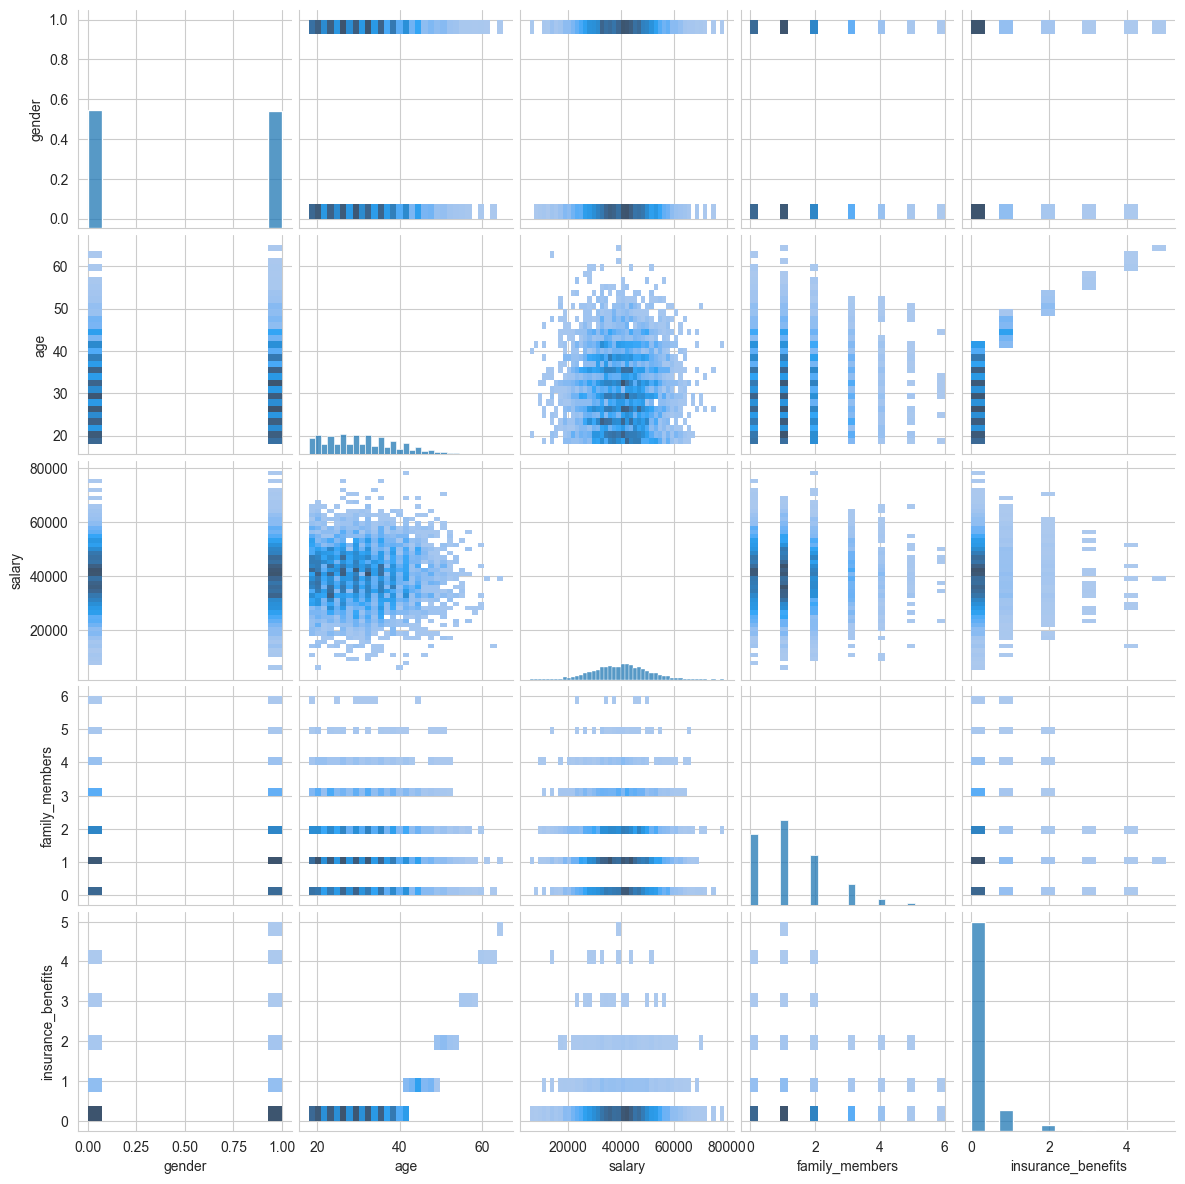

In [216]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

In [217]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [218]:
def get_knn(df, n, k, metric):
    
    """
    Retorna os vizinhos mais próximos de k

    :param df: DataFrame pandas usado para encontrar objetos semelhantes dentro de    
    :param n: número do objeto pelo qual os vizinhos mais próximos são procurados
    :param k: o número dos vizinhos mais próximos a serem retornados
    :param metric: nome da métrica de distância    """

    nbrs = df[feature_names].iloc[n].values
    eval_matrix = df[feature_names].values

    if metric == 'Manhattan':
        distances =  np.abs(nbrs - eval_matrix).sum(axis = 1)
    elif metric == 'Euclidean':
        distances = np.linalg.norm(nbrs-eval_matrix, axis = 1)

    knn_indices = distances.argsort()[:k+1]

    knn_original_df = df.iloc[knn_indices]
    knn_distance_df = pd.DataFrame(
        distances[knn_indices], index=knn_indices, columns=[metric + '_distance']
    )
    
    df_res = pd.concat([knn_original_df, knn_distance_df], axis = 1)
    
    return df_res

In [219]:
feature_names = ['gender', 'age', 'salary', 'family_members']

transformer_mas = MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\User\AppData\Local\Temp\ipykernel_8568\1125340649.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\User\AppData\Local\Temp\ipykernel_8568\1125340649.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [220]:
print('\033[1m', 'Dados Originais')
display(get_knn(df, 4, 5, 'Euclidean'))
display(get_knn(df, 4, 5, 'Manhattan'))


 Dados Originais


,gender,age,salary,family_members,insurance_benefits,Euclidean_distance
4,1,28,26100.0,0,0,0.000000
2643,1,31,26100.0,3,0,4.242641
2714,1,24,26100.0,2,0,4.472136
3259,0,34,26100.0,0,0,6.082763
4577,1,22,26100.0,2,0,6.324555
1491,1,35,26100.0,2,0,7.280110


,gender,age,salary,family_members,insurance_benefits,Manhattan_distance
4,1,28,26100.0,0,0,0.0
2643,1,31,26100.0,3,0,6.0
2714,1,24,26100.0,2,0,6.0
3259,0,34,26100.0,0,0,7.0
4577,1,22,26100.0,2,0,8.0
1491,1,35,26100.0,2,0,9.0


In [221]:
print('\033[1m', 'Dados Escalados')
display(get_knn(df_scaled, 4, 5, 'Euclidean'))
display(get_knn(df_scaled, 4, 5, 'Manhattan'))

 Dados Escalados


,gender,age,salary,family_members,insurance_benefits,Euclidean_distance
4,1,0.430769,0.330380,0.0,0,0.000000
348,1,0.430769,0.322785,0.0,0,0.007595
3823,1,0.430769,0.321519,0.0,0,0.008861
3569,1,0.430769,0.317722,0.0,0,0.012658
1420,1,0.446154,0.331646,0.0,0,0.015437
2408,1,0.446154,0.324051,0.0,0,0.016636


,gender,age,salary,family_members,insurance_benefits,Manhattan_distance
4,1,0.430769,0.330380,0.0,0,0.000000
348,1,0.430769,0.322785,0.0,0,0.007595
3823,1,0.430769,0.321519,0.0,0,0.008861
3569,1,0.430769,0.317722,0.0,0,0.012658
1420,1,0.446154,0.331646,0.0,0,0.016650
2408,1,0.446154,0.324051,0.0,0,0.021714


### Conclusões da Sessão:

- Os dados utilizados foram os dados originais e os dados escalados entre 0 e 1.
- Os resultados de distância para os dados escalados quando comparado com os dados originais mostra que escalar os dados afeta diretamente o resultado final
- Os dados originais na distância euclidiana mostra que os clientes apresentam diferenças de similaridades, entretanto quando mudamos para a distância de Manhattan, verificamos alguns clientes iguais como o 2643 e 2714, com distância de 6.0
- Quando analisamos os dados escalados, verificamos valores menores de distância. Além disso, os valores para a distância euclidiana e de manhattan são muito parecidas, havendo diferença apenas na 5 e 6 linha. 

# Chance de um cliente receber o pagamento do seguro

In [222]:
def eval_classifier(y_true, y_pred):
    
    f1 = f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')
    
# se você tiver um problema com a linha a seguir, reinicie o kernel e execute o caderno novamente
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de Confusão')
    print(cm)
    
    return f1, cm

In [223]:
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [224]:
def upsample(features, target, repeat):

	# Divisão de dados
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
		
	# Multiplicação dos dados e criação de novas amostras
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
	
	# Embaralhar os dados
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [225]:
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
print(df['insurance_benefits_received'].value_counts(normalize=True))

df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)
print(df_scaled['insurance_benefits_received'].value_counts(normalize=True))

insurance_benefits_received
0    0.883846
1    0.116154
Name: proportion, dtype: float64
insurance_benefits_received
0    0.883846
1    0.116154
Name: proportion, dtype: float64


- Os dados apresentam desbalanceamento
- É necessário balancear o modelo de treinamento para não criar um resultado enviesado

In [226]:
features = df.drop(columns=['insurance_benefits', 'insurance_benefits_received'])
target = df['insurance_benefits_received']

features_scaled = df_scaled.drop(columns=['insurance_benefits', 'insurance_benefits_received'])
target_scaled = df_scaled['insurance_benefits_received']

In [227]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled = train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=12345)

In [228]:
for P in [0, target_test.sum() / len(target_test), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P=P, size=len(target_test))
        
    eval_classifier(target_test, y_pred_rnd)
    
    print()

A probabilidade: 0.00
F1: 0.00
Matriz de Confusão
[[0.88453608 0.        ]
 [0.11546392 0.        ]]

A probabilidade: 0.12
F1: 0.16
Matriz de Confusão
[[0.78350515 0.10103093]
 [0.09690722 0.0185567 ]]

A probabilidade: 0.50
F1: 0.22
Matriz de Confusão
[[0.45498282 0.42955326]
 [0.04948454 0.06597938]]

A probabilidade: 1.00
F1: 0.21
Matriz de Confusão
[[0.         0.88453608]
 [0.         0.11546392]]



#### Dados Originais Sem Balanceamento

In [229]:
original_unbalanced = []
for k in range(1, 11):
    print(f"K: {k}")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_train,target_train)
    predictions = model.predict(features_test)
    f1, cm=eval_classifier(target_test,predictions)
    print()
    # Store the f1 score
    original_unbalanced.append(f1)
    print()

K: 1
F1: 0.67
Matriz de Confusão
[[0.86323024 0.02130584]
 [0.04604811 0.06941581]]


K: 2
F1: 0.38
Matriz de Confusão
[[0.87972509 0.004811  ]
 [0.08728522 0.02817869]]


K: 3
F1: 0.38
Matriz de Confusão
[[0.87079038 0.0137457 ]
 [0.08522337 0.03024055]]


K: 4
F1: 0.18
Matriz de Confusão
[[0.8790378  0.00549828]
 [0.10378007 0.01168385]]


K: 5
F1: 0.23
Matriz de Confusão
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]


K: 6
F1: 0.06
Matriz de Confusão
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]


K: 7
F1: 0.07
Matriz de Confusão
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]


K: 8
F1: 0.00
Matriz de Confusão
[[0.88453608 0.        ]
 [0.11546392 0.        ]]


K: 9
F1: 0.01
Matriz de Confusão
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]


K: 10
F1: 0.00
Matriz de Confusão
[[0.88453608 0.        ]
 [0.11546392 0.        ]]




#### Dados Originais Balanceado por Superamostragem

In [230]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [231]:
original_balanced =[]
for k in range(1, 11):
    print(f"K: {k}")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_upsampled,target_upsampled)
    predictions = model.predict(features_test)
    f1, cm=eval_classifier(target_test,predictions)
    print()
    original_balanced.append(f1)

K: 1
F1: 0.67
Matriz de Confusão
[[0.86185567 0.02268041]
 [0.04536082 0.07010309]]

K: 2
F1: 0.67
Matriz de Confusão
[[0.86185567 0.02268041]
 [0.04604811 0.06941581]]

K: 3
F1: 0.62
Matriz de Confusão
[[0.83642612 0.04810997]
 [0.04123711 0.0742268 ]]

K: 4
F1: 0.62
Matriz de Confusão
[[0.83642612 0.04810997]
 [0.04123711 0.0742268 ]]

K: 5
F1: 0.58
Matriz de Confusão
[[0.80343643 0.08109966]
 [0.03573883 0.07972509]]

K: 6
F1: 0.58
Matriz de Confusão
[[0.80412371 0.08041237]
 [0.03573883 0.07972509]]

K: 7
F1: 0.54
Matriz de Confusão
[[0.76563574 0.11890034]
 [0.02955326 0.08591065]]

K: 8
F1: 0.39
Matriz de Confusão
[[0.84879725 0.03573883]
 [0.07835052 0.0371134 ]]

K: 9
F1: 0.39
Matriz de Confusão
[[0.83024055 0.05429553]
 [0.0742268  0.04123711]]

K: 10
F1: 0.39
Matriz de Confusão
[[0.83024055 0.05429553]
 [0.0742268  0.04123711]]



#### Dados Escalados Sem Balanceamento

In [232]:
scaled_unbalanced =[]
for k in range(1, 11):
    print(f"K: {k}")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_train_scaled,target_train_scaled)
    predictions = model.predict(features_test_scaled)
    f1, cm=eval_classifier(target_test_scaled,predictions)
    print()
    scaled_unbalanced.append(f1)

K: 1
F1: 0.93
Matriz de Confusão
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]

K: 2
F1: 0.89
Matriz de Confusão
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]

K: 3
F1: 0.91
Matriz de Confusão
[[0.88041237 0.00412371]
 [0.01649485 0.09896907]]

K: 4
F1: 0.88
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.0233677  0.09209622]]

K: 5
F1: 0.89
Matriz de Confusão
[[0.87972509 0.004811  ]
 [0.0185567  0.09690722]]

K: 6
F1: 0.87
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

K: 7
F1: 0.90
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.01924399 0.09621993]]

K: 8
F1: 0.86
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]

K: 9
F1: 0.87
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

K: 10
F1: 0.86
Matriz de Confusão
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]



#### Dados Escalados Balanceados por Superamostragem

In [233]:
features_upsampled_scaled, target_upsampled_scaled = upsample(features_train_scaled, target_train_scaled, 4)

In [234]:
scaled_balanced =[]
for k in range(1, 11):
    print(f"K: {k}")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_upsampled_scaled,target_upsampled_scaled)
    predictions = model.predict(features_test_scaled)
    f1, cm=eval_classifier(target_test_scaled,predictions)
    print()
    scaled_balanced.append(f1)

K: 1
F1: 0.93
Matriz de Confusão
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]

K: 2
F1: 0.93
Matriz de Confusão
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]

K: 3
F1: 0.94
Matriz de Confusão
[[0.87628866 0.00824742]
 [0.004811   0.11065292]]

K: 4
F1: 0.94
Matriz de Confusão
[[0.87628866 0.00824742]
 [0.004811   0.11065292]]

K: 5
F1: 0.91
Matriz de Confusão
[[0.86597938 0.0185567 ]
 [0.00412371 0.11134021]]

K: 6
F1: 0.91
Matriz de Confusão
[[0.86597938 0.0185567 ]
 [0.00412371 0.11134021]]

K: 7
F1: 0.89
Matriz de Confusão
[[0.8604811  0.02405498]
 [0.00343643 0.11202749]]

K: 8
F1: 0.91
Matriz de Confusão
[[0.87285223 0.01168385]
 [0.00893471 0.10652921]]

K: 9
F1: 0.92
Matriz de Confusão
[[0.87079038 0.0137457 ]
 [0.00549828 0.10996564]]

K: 10
F1: 0.92
Matriz de Confusão
[[0.87079038 0.0137457 ]
 [0.00549828 0.10996564]]



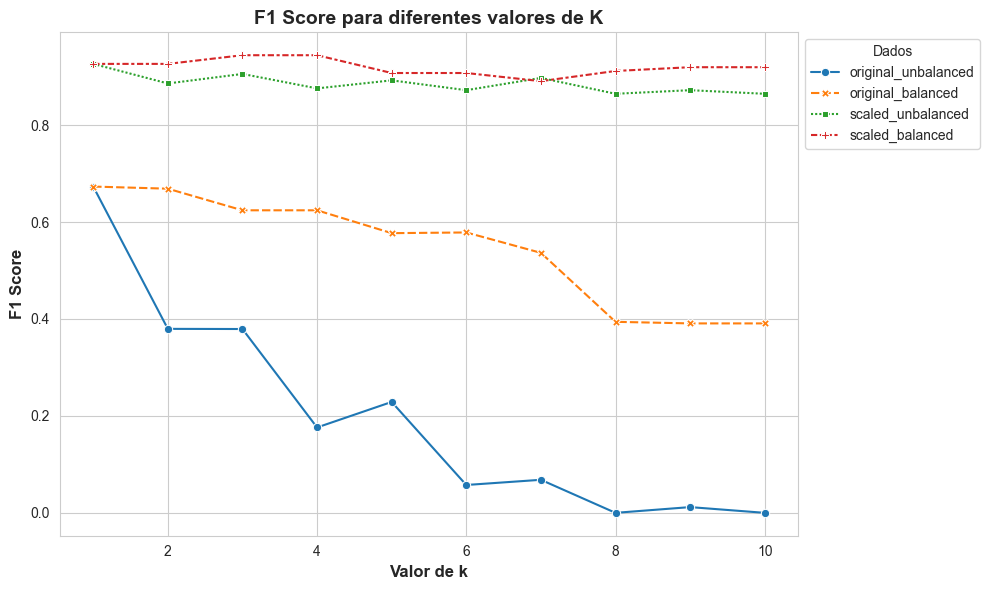

In [235]:
# Criar o DataFrame
f1_result = pd.DataFrame({
    'data': (['original_unbalanced'] * 10) + 
            (['original_balanced'] * 10) + 
            (['scaled_unbalanced'] * 10) + 
            (['scaled_balanced'] * 10),
    'k': list(range(1, 11)) * 4,
    'f1': original_unbalanced + original_balanced + scaled_unbalanced + scaled_balanced
})

# Plotar os resultados
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

sns.lineplot(data=f1_result, x='k', y='f1', hue='data', style='data', markers=True)

plt.title('F1 Score para diferentes valores de K', fontsize=14, fontweight='bold')
plt.xlabel('Valor de k', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.legend(title='Dados', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Conclusões da Sessão:

- Os dados apresentaram desbalanceamento dos dados de treinamento, sendo necessário realizar um balanceamento por superamostragem de dados
- A evolução dos dados com variação até k = 10 mostrou que os dados scaled_balanced com superamostragem apresentam um modelo KNN de desempenho superior aos outros, com F1 acima de 0.9 para todos os valores.
- O modelo dummy apresentou desempenho baixo com resultados de F1 de 0%, 16%, 22% e 21% para as probabilidades de 0, 12%, 50% e 100%.

# Regressão Linear

In [236]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # somando as unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # somando as unidades
        X3 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X3 @ self.weights
        
        return y_pred

In [237]:
def eval_regressor(y_true, y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'REQM: {rmse:.2f}')
    
    r2 = r2_score(y_true, y_pred)
    print(f'R2: {r2:.2f}')  

#### Dados Originais

In [255]:
lr_original_unb = LinearRegression()
lr_original_unb.fit(features_train, target_train)
lr_original_unb_pred = lr_original_unb.predict(features_test)
eval_regressor(target_test, lr_original_unb_pred)

REQM: 0.24
R2: 0.44


#### Dados Escalonados

In [251]:
# Scaled the data
mas = MaxAbsScaler()
X_train_scaled = mas.fit_transform(features_train)
X_test_scaled = mas.transform(features_test)

In [254]:
lr_scaled_unb = LinearRegression()
lr_scaled_unb.fit(X_train_scaled, target_train)
lr_scaled_unb_pred = lr_scaled_unb.predict(X_test_scaled)
eval_regressor(target_test, lr_scaled_unb_pred)

REQM: 0.24
R2: 0.44


### Conclusões da Sessão:

- Os dados de avaliação da regressão linear REQM e R2 apontam para valores idênticos.
- A predição da quantidade de benefícios recebidas pelos clientes pode ser observada utilizando uma regressão linear sem a necessidade de escalonar os dados, como é feito no modelo KNN.

# Ofuscando os Dados

In [257]:
personal_info_column_list = ['gender', 'age', 'salary', 'family_members']
df_pn = df[personal_info_column_list]

In [260]:
X = df_pn.to_numpy()

In [261]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [262]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [264]:
X_obfuscated = X @ P
data_obfuscated = pd.DataFrame(X_obfuscated, columns=personal_info_column_list)
display(data_obfuscated)

,gender,age,salary,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4842,4577.581382,16107.740932,13259.688205,33107.974380
4843,6717.000247,23634.217067,19456.138634,48589.438841
4844,4346.223425,15289.241265,12586.162644,31433.508886
4845,4194.093242,14751.991024,12144.029306,30323.887634


In [266]:
X_decrypted = X_obfuscated @ np.linalg.inv(P)
data_decrypted = pd.DataFrame(X_decrypted, columns=personal_info_column_list)
display(data_decrypted)

,gender,age,salary,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13
...,...,...,...,...
4842,-2.559766e-12,28.0,35700.0,2.000000e+00
4843,-5.486091e-12,34.0,52400.0,1.000000e+00
4844,-1.928379e-12,20.0,33900.0,2.000000e+00
4845,1.000000e+00,22.0,32700.0,3.000000e+00


In [267]:
np.allclose(X, X_decrypted)

True

In [269]:
data_decrypted.update(pd.DataFrame(abs(X_decrypted.round()), columns = personal_info_column_list))

In [270]:
print('\033[1m', 'Dados Originais')
display(df_pn.head(3))
print('*' * 50)

print('\033[1m', 'Dados Ofuscados')
display(data_obfuscated.head(3))
print('*' * 50)

print('\033[1m', 'Dados Recuperados')
display(data_decrypted.head(3))

 Dados Originais


,gender,age,salary,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0


**************************************************
 Dados Ofuscados


,gender,age,salary,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631


**************************************************
 Dados Recuperados


,gender,age,salary,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0


### Conclusões da Sessão:

- As informações pessoais dos clientes podem ser ofuscadas ao multiplicar os dados pela matriz quadrada P que deve ser invertível.
- Os dados foram recuperados com alguns problemas de arredondamento de valores próximos a zero que foram corrigidos ao utilizar os valores absolutos.

# Prova Matemática de que os dados ofuscados podem ser utilizados com Regressão Linear

$$\begin{align*}
y &= Xw \tag{1} \\
y_{p} &= X_{p}w_{p} \tag{2} \\
\end{align*}$$

Onde:

$$\begin{align*}
X_{p} &= XP \tag{3} \\
w &= (X^T X)^{-1} X^T y \tag{4} \\
w_{p} &= [(XP)^T XP]^{-1} (XP)^T y \tag{5}
\end{align*}$$

Para provar que a Regressão Linear irá funcionar com os dados ofuscados, é necessário provar que:

$$
y_{p} = y
$$

Logo:

De (5)
$$\begin{align*}
w_{p} &= [(XP)^T XP]^{-1} (XP)^T y \\
&= (P^T X^T XP)^{-1} (XP)^T y \\
&= [(P^T X^T X) P]^{-1} (XP)^T y \\
&= P^{-1} (P^T X^T X)^{-1} (XP)^T y \\
&= P^{-1} [P^T (X^T X)]^{-1} (XP)^T y \\
&= P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y \\
&= P^{-1} (X^T X)^{-1} [(P^T)^{-1} P^T] X^T y \\
&= P^{-1} (X^T X)^{-1} I X^T y \\
&= P^{-1} (X^T X)^{-1} (I X^T) y \\
\therefore w_{p} &= P^{-1} [(X^T X)]^{-1} X^T y \tag{6} \\
\end{align*}$$

Substituindo (4) em (6)

$$\begin{align*}
w_{p} &= P^{-1} w \tag{7} \\
\end{align*}$$

Substituindo (3) e (7) em (2)
$$\begin{align*}
y_{p} &= XP P^{-1}w \tag{2} \\
&= X(P P^{-1}) w \\
&= XIw \\
&= Xw \\
\therefore y_{p} &= y
\end{align*}$$

# Teste da Regressão Linear com Dados Ofuscados

**Procedimento**
- Criar uma matriz quadrada P de números aleatórios
- Checar se a matriz P é invertível. Caso não seja, repetir o primeiro ponto até conseguir uma matriz invertível
- Multiplicar as características de treinamento 'X_train' e testar as características da matriz 'X_test' por P.
- Usar X_test.P para treinar e X_test.P para avaliar o modelo

In [271]:
n = features_train.shape[1]
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(n,n))

In [272]:
np.linalg.inv(P)

array([[-1.97240014,  1.76004024, -0.08309671,  1.22285233],
       [ 0.14111106,  0.32873452,  1.02824721, -1.27752175],
       [ 0.8908452 ,  0.90302415, -0.59501472, -0.23290483],
       [ 1.02530945, -1.81039816,  0.24787878,  0.46192295]])

In [274]:
X_train_P = pd.DataFrame(features_train.values @ P, columns=features_train.columns)
X_test_P = pd.DataFrame(features_test.values @ P, columns=features_test.columns)

print('\033[1m', 'Dados Ofuscados de treinamento:')
display(X_train_P.head())
print('*' * 60)

print('\033[1m', 'Dados Ofuscados de Teste:')
display(X_test_P.head())

 Dados Ofuscados de treinamento:


,gender,age,salary,family_members
0,24968.748217,34948.620864,9224.318010,35209.161620
1,28342.354967,39665.401864,10479.550468,39958.259225
2,27995.646951,39186.653916,10340.782830,39477.750803
3,31497.107256,44086.691326,11636.447016,44413.426666
4,22074.332789,30897.537288,8154.468203,31128.225730


************************************************************
 Dados Ofuscados de Teste:


,gender,age,salary,family_members
0,31763.308133,44461.066719,11731.756197,44792.161507
1,44347.366142,62075.775625,16379.335840,62537.919654
2,22820.898318,31938.608546,8436.954960,32175.682490
3,13000.779397,18189.966839,4815.360013,18322.461823
4,18520.116725,25915.080031,6855.163034,26104.594408


#### Teste com o MyLinearRegression

In [275]:
lr_obfuscated = MyLinearRegression()
lr_obfuscated.fit(X_train_P, target_train)
lr_obfuscated_pred = lr_obfuscated.predict(X_test_P)
eval_regressor(target_test, lr_obfuscated_pred)

REQM: 0.24
R2: 0.44


#### Teste com o LinearRegression do Scikit-Learn

In [276]:
lr_obfuscated_skl = LinearRegression()
lr_obfuscated_skl.fit(X_train_P, target_train)
lr_obfuscated_skl_pred = lr_obfuscated_skl.predict(X_test_P)
eval_regressor(target_test, lr_obfuscated_skl_pred)

REQM: 0.24
R2: 0.44


### Conclusões da Sessão:

- Foi possível provar analíticamente que a transformação não afeta o REQM
- O modelo computacional provou com números que o valor do REQM e R2 é o mesmo que o calculado anteriormente para os dados originais e escalonados
- O modelo foi comparado ao LinearRegression do scikit-learn e foi obtido o mesmo resultado, comprovando a eficiência do método.

# Conclusões Gerais do Projeto

#### Estrutura e Limpeza de Dados
- **Estrutura do DataFrame**: 5000 linhas e 5 colunas.
- **Alteração de Tipo**: Coluna de idade convertida de float para int.
- **Dados Duplicados**: 3,06% duplicados; eliminados por ser uma baixa representatividade.
- **Descrição dos Dados**: Não apresentou necessidade de investigação adicional.

#### Pré-processamento
- **Escalonamento**: Dados originais e escalados entre 0 e 1 utilizados.
- **Impacto do Escalonamento**:
  - Afeta diretamente os resultados das distâncias.
  - Dados escalados apresentaram distâncias menores.
  - Distância euclidiana e Manhattan em dados escalados foram muito semelhantes, com diferenças apenas nas linhas 5 e 6.

#### Análise de Distâncias
- **Dados Originais**:
  - Diferenças de similaridade observadas entre clientes pela distância euclidiana.
  - Distância Manhattan identificou clientes com distâncias iguais (ex.: cliente 2643 e 2714 com distância 6.0).
- **Dados Escalados**:
  - Distâncias menores.
  - Similaridade entre resultados de distâncias euclidiana e Manhattan.

#### Balanceamento e Modelagem
- **Desbalanceamento**: Dados de treinamento balanceados por superamostragem.
- **Desempenho do Modelo KNN**:
  - Dados balanceados e escalados apresentaram F1 superior a 0.9 para \( k $\leq 10$ \).
- **Modelo Dummy**:
  - Baixo desempenho: F1 de 0%, 16%, 22% e 21% para probabilidades de 0, 12%, 50% e 100%.

#### Regressão Linear
- **Desempenho**:
  - REQM e \( $R^2$ \) idênticos entre dados originais e escalados.
  - Predição da quantidade de benefícios possível sem necessidade de escalonamento.
- **Privacidade dos Dados**:
  - Dados pessoais ofuscados utilizando matriz quadrada invertível \( P \).
  - Recuperação apresentou problemas de arredondamento corrigidos com valores absolutos.
- **Provas de Consistência**:
  - Transformação analiticamente provada como não afetando o REQM.
  - Modelo computacional corroborou a igualdade de REQM e \( $R^2$ \) para dados originais e escalonados.
  - Resultados alinhados com o modelo LinearRegression do scikit-learn.